## Important
This notebook was taken from 
https://github.com/jaypatel00174/Movie-Recommendation.git
and modified for AI introduction purpose.

In this notebook, you will see the following:
* A **Regressor** that can, to a certain degree, predict the revenue of a particular movie.
* A **Classifier** that identifies if a movie will be a hit or will make the producers lose money.


## Importing Libraries and Loading Our Data

In [2]:
%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS
#import plotly
#import plotly.plotly as py
# plotly.tools.set_credentials_file(username='rounakbanik', api_key='xTLaHBy9MVv5szF4Pwan')
from warnings import filterwarnings

filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

## Understanding the Data

The dataset above was obtained through the TMDB API. The movies available in this dataset are in correspondence with the movies that are listed in the **MovieLens Latest Full Dataset** comprising of 26 million ratings on 45,000 movies from 27,000 users.
There are a total of 45,466 movies with 24 features. Most of the features have very few NaN values (apart from homepage and tagline). We will attempt at cleaning this dataset to a form suitable for analysis in the next section.

In [3]:
df = pd.read_csv('../data/movies_metadata.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

### Features

* **adult:** Indicates if the movie is X-Rated or Adult.
* **belongs_to_collection:** A stringified dictionary that gives information on the movie series the particular film belongs to.
* **budget:** The budget of the movie in dollars.
* **genres:** A stringified list of dictionaries that list out all the genres associated with the movie.
* **homepage:** The Official Homepage of the move.
* **id:** The ID of the move.
* **imdb_id:** The IMDB ID of the movie.
* **original_language:** The language in which the movie was originally shot in.
* **original_title:** The original title of the movie.
* **overview:** A brief blurb of the movie.
* **popularity:** The Popularity Score assigned by TMDB.
* **poster_path:** The URL of the poster image.
* **production_companies:** A stringified list of production companies involved with the making of the movie.
* **production_countries:** A stringified list of countries where the movie was shot/produced in.
* **release_date:** Theatrical Release Date of the movie.
* **revenue:** The total revenue of the movie in dollars.
* **runtime:** The runtime of the movie in minutes.
* **spoken_languages:** A stringified list of spoken languages in the film.
* **status:** The status of the movie (Released, To Be Released, Announced, etc.)
* **tagline:** The tagline of the movie.
* **title:** The Official Title of the movie.
* **video:** Indicates if there is a video present of the movie with TMDB.
* **vote_average:** The average rating of the movie.
* **vote_count:** The number of votes by users, as counted by TMDB.

## Data Wrangling

Let us start by removing the features that are not useful to us.

In [4]:
df[df['original_title'] != df['title']][['title', 'original_title']].head()

,title,original_title
28,The City of Lost Children,La Cité des Enfants Perdus
29,Shanghai Triad,摇啊摇，摇到外婆桥
32,Wings of Courage,"Guillaumet, les ailes du courage"
57,The Postman,Il postino
58,The Confessional,Le confessionnal


In [5]:
df = df.drop('original_title', axis=1)
df['revenue'] = df['revenue'].replace(0, np.nan) # Replace 0 revenue input by NaN
df['budget'] = pd.to_numeric(df['budget'], errors='coerce') #  Convert this into a numeric variable
df['budget'] = df['budget'].replace(0, np.nan) # Replace 0 budget input by NaN

Features creation:
* **year:** The year in which the movie was released.
* **return:** The ratio of revenue to budget.

A return value > 1 would indicate profit whereas a return value < 1 would indicate a loss.

In [6]:
df['return'] = df['revenue'] / df['budget']
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

df = df.drop('adult', axis=1) # There are 0 adult movie in this dataset so we remove this column
df = df.drop(['imdb_id'], axis=1) # Remove the internal IMDB ID

## Exploratory Data Analysis
### Production Countries

Are there certain words that figure more often in Movie Titles and Movie Blurbs? I suspect there are some words which are considered more potent and considered more worthy of a title. Let us find out!

In [7]:
# Modification of labels of production_companies to standard country name
# print(df['production_countries'])
con_df = df['production_countries'][::].fillna('[]').apply(ast.literal_eval)
con_df = pd.DataFrame(con_df.apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else []).value_counts())
con_df['country'] = con_df.index
con_df.columns = ['num_movies','country']
con_df = con_df.reset_index().drop('index', axis=1).reindex(columns=['country','num_movies'])
con_df['country'] = con_df['country'].astype(str).map(lambda x: str(x)[2:-2])
con_df = con_df.drop([1])

plt.figure(figsize=(12,5))
sns.barplot(x='country', y='num_movies', data=con_df.iloc[0:10])
plt.show()

TypeError: unhashable type: 'list'

### Original Language

In this section, let us look at the languages of the movies in our dataset. From the production countries, we have already deduced that the majority of the movies in the dataset are English. Let us see what the other major languages represented are.

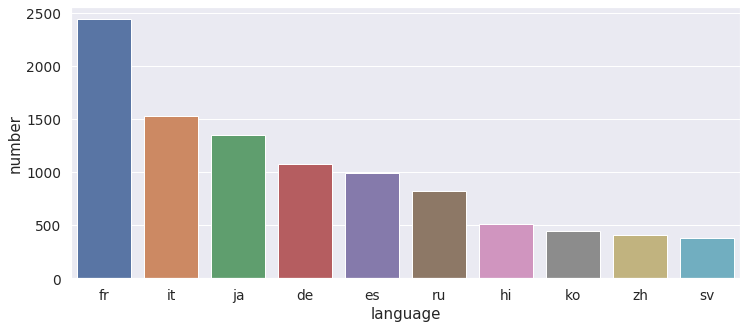

In [8]:
lang_df = pd.DataFrame(df['original_language'].value_counts())
lang_df['language'] = lang_df.index
lang_df.columns = ['number', 'language']

plt.figure(figsize=(12,5))
sns.barplot(x='language', y='number', data=lang_df.iloc[1:11])
plt.show()

### Franchise Movies

Let us now have a brief look at Franchise movies. I was curious to discover the longest running and the most successful franchises among many other things. Let us wrangle our data to find out!

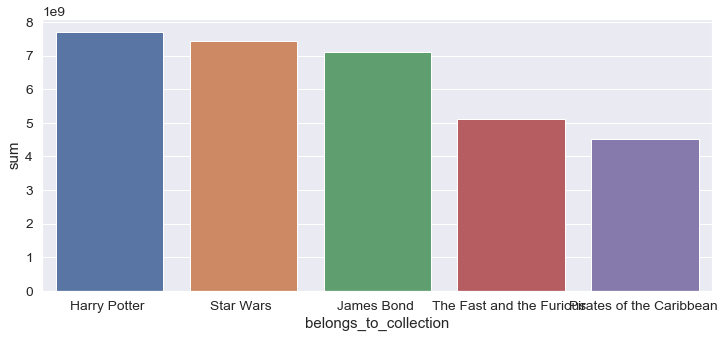

In [8]:
df_fran = df[df['belongs_to_collection'].notnull()]
df_fran['belongs_to_collection'] = df_fran['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
fran_pivot = df_fran.pivot_table(index='belongs_to_collection', values='revenue', aggfunc={'revenue': ['mean', 'sum', 'count']}).reset_index()
fran_pivot["belongs_to_collection"] = fran_pivot["belongs_to_collection"].str.replace("Collection", "")
plt.figure(figsize=(12,5))
sns.barplot(x='belongs_to_collection', y='sum', data=fran_pivot.sort_values('sum', ascending=False).iloc[0:5])
plt.show()

The **Harry Potter** Franchise is the most successful movie franchise raking in more than 7.707 billion dollars. The **Star Wars** Movies come in a close second with a 7.403 billion dollars from 8 movies too. **James Bond**
is third but the franchise has significantly more movies compared to the others in the list and therefore, a much smaller average gross.
Also, it seems that movies that belong to a franchise have a higher probability of being a success. 

### Popularity, Vote Average and Vote Count

In this section, we will work with metrics provided to us by TMDB users. We will try to gain a deeper understanding of the popularity, vote average and vote count features and try and deduce any relationships between them as well as other numeric features such as budget and revenue.

In [9]:
# This function is used to convert value into float type digits or NaN
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

#### Most Popular Movies by Popularity Score

In [10]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float').replace(0, np.nan) # Replace 0 value with NaN
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float').replace(0, np.nan) # Replace 0 value with NaN
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float').replace(0, np.nan) # Replace 0 value with NaN

In [12]:
pop = df[['title', 'popularity', 'year','vote_average','vote_count']].sort_values('popularity', ascending=False) # Sort and display

In [14]:
len(pop)

45466

In [13]:
pop.head(n=10)

,title,popularity,year,vote_average,vote_count
30700,Minions,547.488298,2015,6.4,4729.0
33356,Wonder Woman,294.337037,2017,7.2,5025.0
42222,Beauty and the Beast,287.253654,2017,6.8,5530.0
43644,Baby Driver,228.032744,2017,7.2,2083.0
24455,Big Hero 6,213.849907,2014,7.8,6289.0
26564,Deadpool,187.860492,2016,7.4,11444.0
26566,Guardians of the Galaxy Vol. 2,185.330992,2017,7.6,4858.0
14551,Avatar,185.070892,2009,7.2,12114.0
24351,John Wick,183.870374,2014,7.0,5499.0
23675,Gone Girl,154.801009,2014,7.9,6023.0


Store the above dataframe **pop** so it can be used in the **contextual_bandit** notebook.

In [15]:
%store pop

Stored 'pop' (DataFrame)


**Minions** is the most popular movie by the TMDB Popularity Score. **Wonder Woman** and **Beauty and the Beast**, two extremely successful woman centric movies come in second and third respectively.

In [18]:
df['vote_average'] = df['vote_average'].fillna(df['vote_average'].median()) # Filter [] values with median value
df['popularity'] = df['popularity'].fillna(df['popularity'].median()) # Filter [] values with median value
df['vote_count'] = df['vote_count'].fillna(df['vote_count'].median()) # Filter [] values with median value

# df['vote_average'].describe()
# df['popularity'].describe()
df['vote_count'].describe()


count    45466.000000
mean       110.585668
std        491.129715
min          1.000000
25%          4.000000
50%         11.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

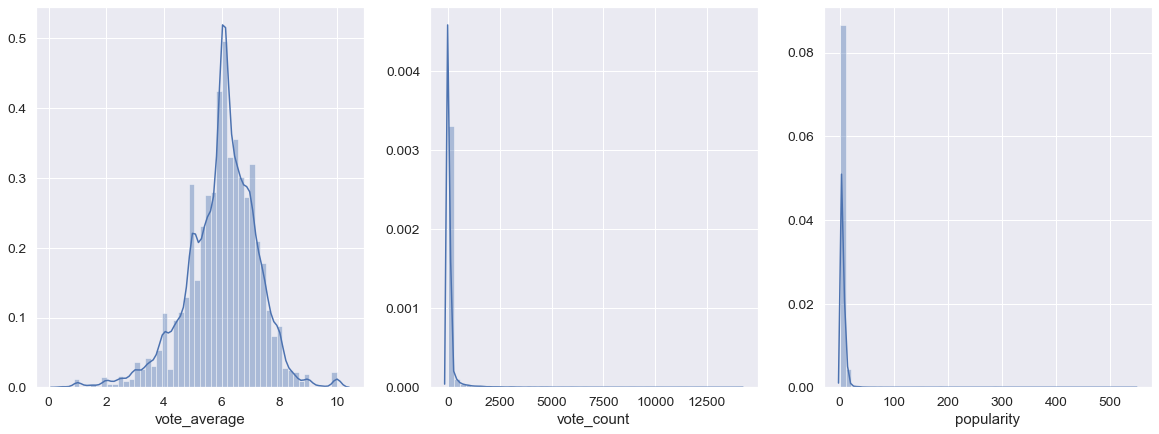

In [19]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
sns.distplot(df['vote_average'])
plt.subplot(1,3,2)
sns.distplot(df['vote_count'])
plt.subplot(1,3,3)
sns.distplot(df['popularity'])


Do popularity and vote average share a tangible relationship? In other words, is there a strong positive correlation between these two quantities? Let us visualise their relationship in the form of a scatterplot.

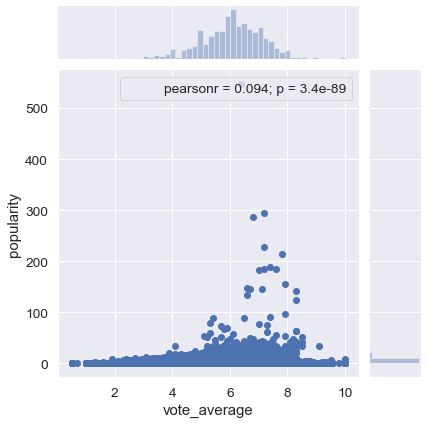

In [20]:
sns.jointplot(x='vote_average', y='popularity', data=df).annotate(stats.pearsonr)

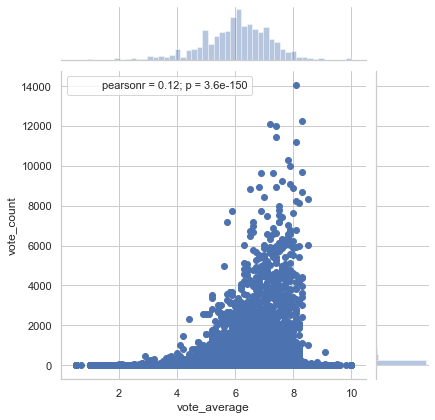

In [16]:
sns.jointplot(x='vote_average', y='vote_count', data=df).annotate(stats.pearsonr)

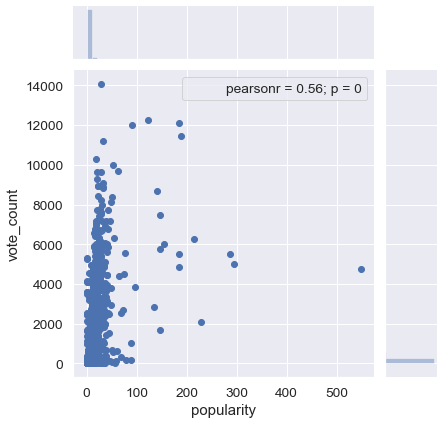

In [21]:
sns.jointplot(x='popularity', y='vote_count', data=df).annotate(stats.pearsonr)

The Pearson Coefficient of the 'Popularity' and 'vote_average' is **0.094** which suggests that **there is no tangible correlation**.
The Pearson Coefficient of the 'vote_count' and 'vote_average' is **0.097** which suggests that **there is a correlation**. 
The Pearson Coefficient of the 'Popularity' and 'vote_count' is **0.56** which suggests that **there might be a  correlation**.

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

### Runtime


In [22]:
df['runtime'].describe()

count    45203.000000
mean        94.128199
std         38.407810
min          0.000000
25%         85.000000
50%         95.000000
75%        107.000000
max       1256.000000
Name: runtime, dtype: float64

In [23]:
df['runtime'] = df['runtime'].astype('float')

We are aware that most movies are less than 5 hours (or 300 minutes) long. Let us plot a distribution of these mainstream movies.

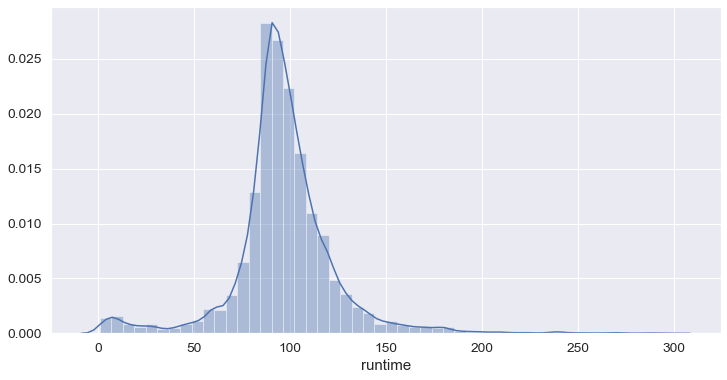

In [24]:
plt.figure(figsize=(12,6))
sns.distplot(df[(df['runtime'] < 300) & (df['runtime'] > 0)]['runtime'])

Is there any meaningful relationship between runtime and return? Let us find out!

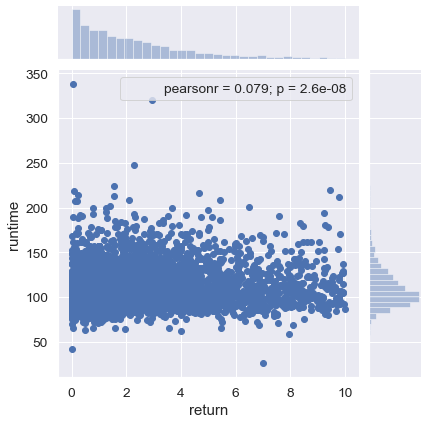

In [25]:
df_mat = df[(df['return'].notnull()) & (df['runtime'] > 0) & (df['return'] < 10)]
sns.jointplot('return', 'runtime', data=df_mat).annotate(stats.pearsonr)
plt.show()

There seems to be no relationship between the two quantities. **The duration of a movie is independent of its success.** 

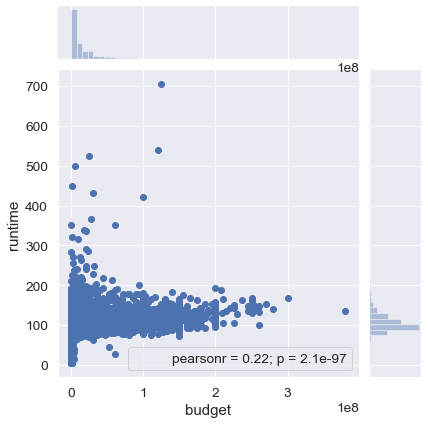

In [26]:
df_mat = df[(df['budget'].notnull()) & (df['runtime'] > 0)]
sns.jointplot('budget', 'runtime', data=df_mat).annotate(stats.pearsonr)

### Budget

Let us now turn our attention to budget. We expect budgets to be a skewed quantity and also heavily influenced by inflation. Nevertheless, it would be interesting to gather as much insights as possible from this quantity as budget is often a critical feature in predicting movie revenue and success. As a start, let us gather the summary statistics for our budget.

In [27]:
df['budget'].describe()

count    8.890000e+03
mean     2.160428e+07
std      3.431063e+07
min      1.000000e+00
25%      2.000000e+06
50%      8.000000e+06
75%      2.500000e+07
max      3.800000e+08
Name: budget, dtype: float64

The mean budget of a film is 21.6 million dollars whereas the median budget is far smaller at 8 million dollars. This strongly suggests the mean being influenced by outliers. 

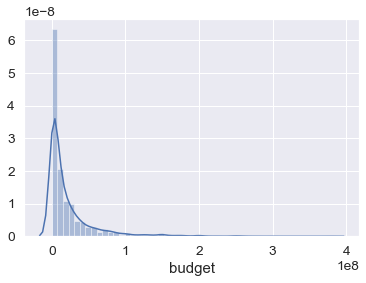

In [28]:
sns.distplot(df[df['budget'].notnull()]['budget'])

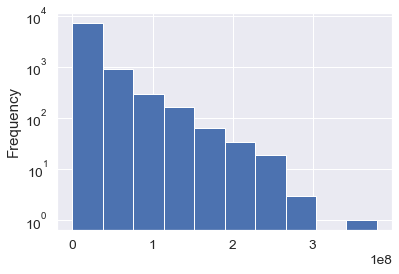

In [29]:
df['budget'].plot(logy=True, kind='hist')

The distribution of movie budgets shows an exponential decay. More than 75% of the movies have a budget smaller than 25 million dollars. Next, let us take a look at the most expensive movies of all time and the revenue & returns that they generated.

#### Most Expensive Movies of all Time

In [30]:
df[df['budget'].notnull()][['title', 'budget', 'revenue', 'return', 'year']].sort_values('budget', ascending=False).head(10)

,title,budget,revenue,return,year
17124,Pirates of the Caribbean: On Stranger Tides,380000000.0,1.045714e+09,2.751878,2011
11827,Pirates of the Caribbean: At World's End,300000000.0,9.610000e+08,3.203333,2007
26558,Avengers: Age of Ultron,280000000.0,1.405404e+09,5.019299,2015
11067,Superman Returns,270000000.0,3.910812e+08,1.448449,2006
44842,Transformers: The Last Knight,260000000.0,6.049421e+08,2.326701,2017
16130,Tangled,260000000.0,5.917949e+08,2.276134,2010
18685,John Carter,260000000.0,2.841391e+08,1.092843,2012
11780,Spider-Man 3,258000000.0,8.908716e+08,3.452991,2007
21175,The Lone Ranger,255000000.0,8.928991e+07,0.350157,2013
22059,The Hobbit: The Desolation of Smaug,250000000.0,9.584000e+08,3.833600,2013


How strong a correlation does the budget hold with the revenue? A stronger correlation would directly imply more accurate forecasts.

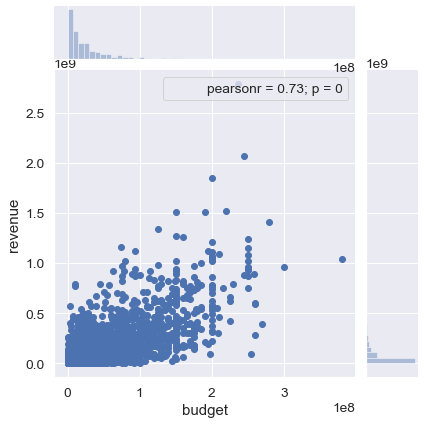

In [31]:
sns.jointplot(x='budget',y='revenue',data=df[df['return'].notnull()]).annotate(stats.pearsonr)

The pearson r value of **0.73** between the two quantities indicates a very strong correlation. 

# Correlation matrix
With these analyses in place, we are in a good position to construct our correlation matrix.

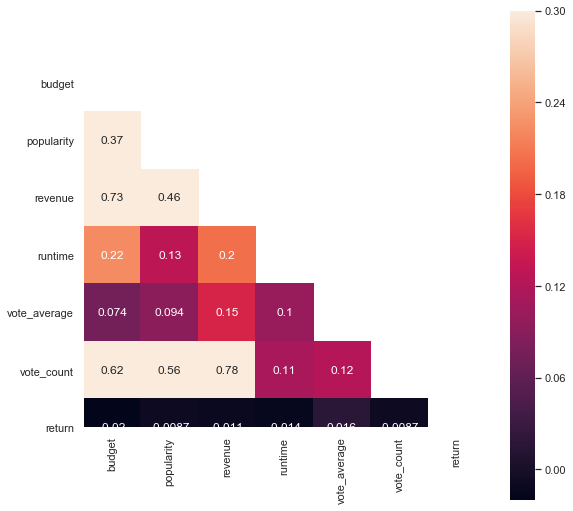

In [32]:
sns.set(font_scale=1)
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(9,9))

with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

## Regression approach: Predicting Movie Revenues

In this section, I will attempt at building a regression model to predict movie revenues.

Predicting Movie Revenues is an extremely popular problem in Machine Learning which has created a huge amount of literature. Most of the models proposed in these papers use far more potent features than what we possess at the moment. These include Facebook Page Likes, Information on Tweets about the Movie, YouTube Trailer Reaction (Views, Likes, Dislikes, etc.), Movie Rating (MPCAA, CBIFC) among many others.

To compensate for the lack of these features, we are going to cheat a little. We will be using TMDB's **Popularity Score** and **Vote Average** as our features in our model to assign a nuerical value to popularity. However, it must be kept in mind that these metrics will not be available when predicting movie revenues in the real world, when the movie has not been released yet.

In [81]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

df['year'] = df['year'].replace('NaT', np.nan)
df['year'] = df['year'].apply(clean_numeric)
df['month'] = df['release_date'].apply(get_month)
df['day'] = df['release_date'].apply(get_day)

rgf = df[df['return'].notnull()]
rgf.shape

(5381, 25)

We have **5393 records** in our training set. Let us take a look at the features we possess and remove the ones which are unnecessary.

In [82]:
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'month',
       'day'],
      dtype='object')

In [83]:
rgf = rgf.drop(['id', 'budget','original_language','spoken_languages', 'genres', 'overview', 'poster_path', 'release_date', 'status', 'tagline', 'video', 'return','title'], axis=1)

We will perform the following feature engineering tasks:

1. **belongs_to_collection** will be turned into a Boolean variable. 1 indicates a movie is a part of collection whereas 0 indicates it is not.
2. **genres** will be converted into number of genres.
3. **homepage** will be converted into a Boolean variable that will indicate if a movie has a homepage or not.
4. **original_language** will be replaced by a feature called **is_foreign** to denote if a particular film is in English or a Foreign Language.
5. **production_companies** will be replaced with just the number of production companies collaborating to make the movie.
6. **production_countries** will be replaced with the number of countries the film was shot in.
7. **day** will be converted into a binary feature to indicate if the film was released on a Friday.
8. **month** will be converted into a variable that indicates if the month was a holiday season.

In [84]:
def feature_engineering(df):
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: 0 if x == np.nan else 1)
    df['homepage'] = df['homepage'].apply(lambda x: 0 if x == np.nan else 1)
    df['production_companies'] = df['production_companies'].apply(lambda x: len(x))
    df['production_countries'] = df['production_countries'].apply(lambda x: len(x))
    df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
    df = df.drop('day', axis=1)
    df['is_Holiday'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Jun', 'Nov'] else 0)
    df = df.drop('month', axis=1)
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['vote_average'] = df['vote_average'].fillna(df['vote_average'].mean())
    return df

In [85]:
# Extract data from df. Select revenue as the prediction target,
X, y = rgf.drop('revenue', axis=1), rgf['revenue']
X = feature_engineering(X)
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [86]:
reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.6090189762519271

In [63]:
dummy = DummyRegressor()
dummy.fit(train_X, train_y)
dummy.score(test_X, test_y)

-0.0003185992033698515

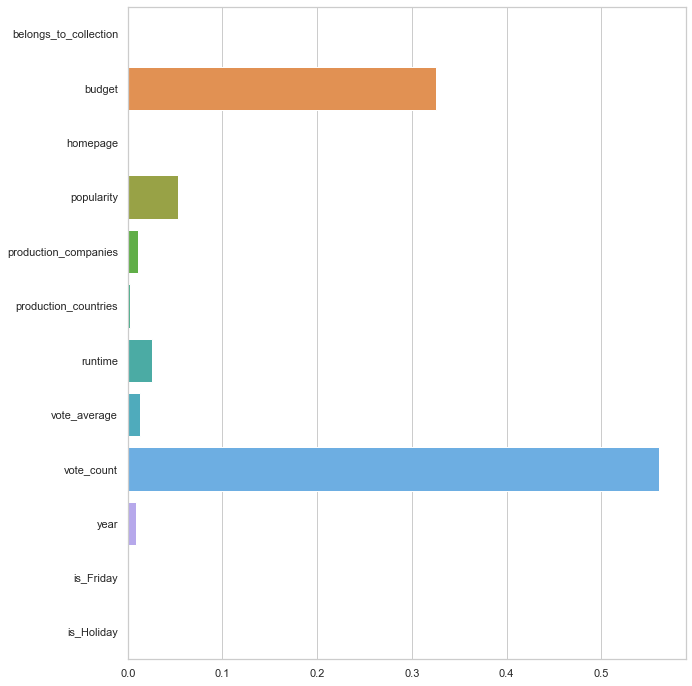

In [64]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

We notice that **vote_count** is the most important feature to our Gradient Boosting Model. **Budget** was the second most important feature followed by **Popularity** (Literally, a popularity metric).

## Classification: Predicting Movie Sucess

What factors influence whether a movie will be able to recoup its investments? 

In [68]:
cls = df[df['return'].notnull()]
cls = cls.drop(['id', 'title', 'video', 'homepage', 'overview', 'genres', 'poster_path', 'release_date', 'status', 'tagline', 'revenue', 'original_language','spoken_languages'], axis=1)

Let us convert our **return** feature into a binary variable that will serve as our classes: **0** indicating a flop and **1** indicating a hit.

In [69]:
cls['return'] = cls['return'].apply(lambda x: 1 if x >=1 else 0)
cls['return'].value_counts()

1    3776
0    1605
Name: return, dtype: int64

Our classes seem to be fairly balanced. We do not need to apply any additional methods to deal with the imbalance of classes. Let us now turn our attention to our features.

In [70]:
def classification_engineering(df):
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: 0 if x == np.nan else 1)
    df['production_companies'] = df['production_companies'].apply(lambda x: len(x))
    df['production_countries'] = df['production_countries'].apply(lambda x: len(x))
    df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
    df = df.drop('day', axis=1)
    df['is_Holiday'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Jun', 'Nov'] else 0)
    df = df.drop('month', axis=1)
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['vote_average'] = df['vote_average'].fillna(df['vote_average'].mean())
    return df

In [71]:
cls = classification_engineering(cls)

In [72]:
cls.columns

Index(['belongs_to_collection', 'budget', 'popularity', 'production_companies',
       'production_countries', 'runtime', 'vote_average', 'vote_count',
       'return', 'year', 'is_Friday', 'is_Holiday'],
      dtype='object')

In [73]:
X, y = cls.drop('return', axis=1), cls['return']

In [74]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y)

In [75]:
clf = GradientBoostingClassifier()
clf.fit(train_X, train_y)
clf.score(test_X, test_y)

0.7763744427934621

Our basic Gradient Boosting Classifier has an accuracy of **78%**. Again, this model can be improved upon through hyperparameter tuning and more advanced feature engineering but since this is not the main objective of this project, I will skip this.

In [76]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(train_X, train_y)
dummy.score(test_X, test_y)
# print(train_X.iloc[0])

0.7020802377414561

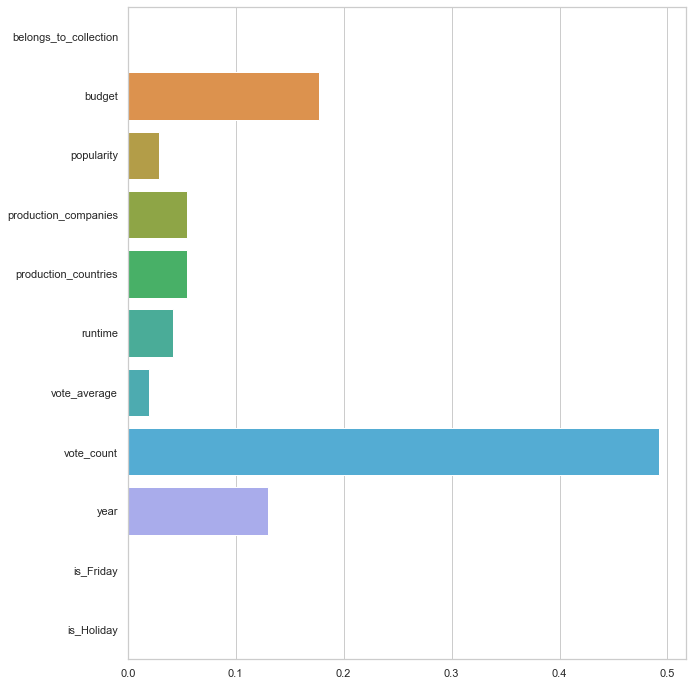

In [77]:
plt.figure(figsize=(10,12))
sns.barplot(x=clf.feature_importances_, y=X.columns)

We see that **Vote Count** is once again the most significant feature identified by our Classifier.

# Exercise:

Try to predict the possible financial success of a movie with the following features.

**belongs_to_collection**                 yes

**budget**                 9 million dollars

**popularity score**               75

**production_companies**     45

**production_countries**     1

**runtime**                  1 hour and 30 minutes

**vote_average**             8

**vote_count**               10

**year**                     2009

**is_Friday**                no

**is_Holiday**               no

In [79]:
d = {'belongs_to_collection': [1], 'budget': [9e6], 'popularity score': [75], 'production_companies': [45], \
     'production_countries': [1], 'runtime': [90], 'vote_average': [8], 'vote_count': [100], 'year': [2009], \
     'is_Friday': [0], 'is_Holiday': [0]}
pred = pd.DataFrame(data=d)

clf.predict(pred)

array([1], dtype=int64)